In [4]:
import torch
from torchdeq import get_deq

import numpy as np
import matplotlib.pyplot as plt

DEQSliced args: core: sliced
f_max_iter: 20
f_solver: broyden
f_tol: 1.0e-06
 ift: False, hook_ift: False, grad: 1, tau: 1.0, sup_gap: -1, sup_loc: None, n_states: 1, indexing: None
DEQSliced indexing set to: [20]
Sliced indexing set to:  [20]
Sliced indexing set to:  [20]
Sliced indexing set to:  [20]
zout 1


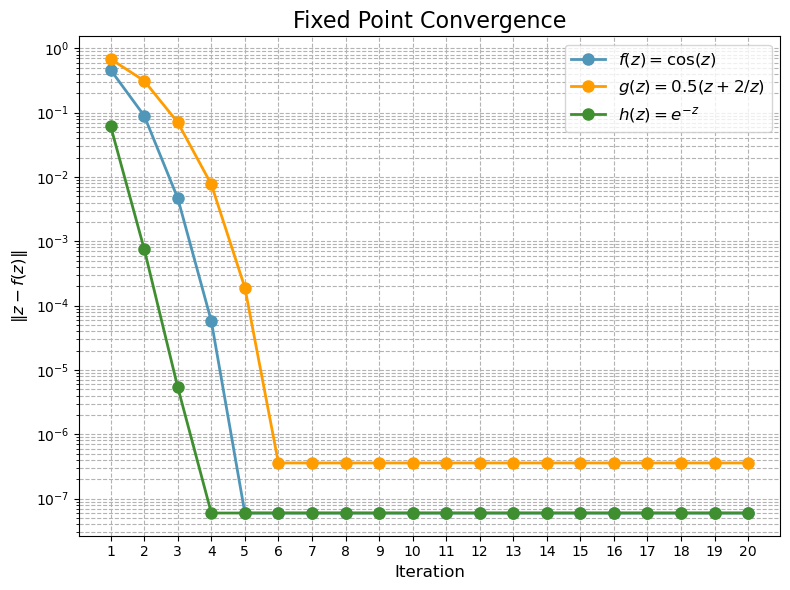

In [5]:
# Define your 1-dim DEQ!
deq = get_deq(core="sliced", f_solver="broyden", f_max_iter=20, f_tol=1e-6)  # default
# deq = get_deq(core='indexing', f_solver='broyden', f_max_iter=20, f_tol=1e-6)

# n_states (int, optional):indexing
f = lambda z: torch.cos(z)
z0 = torch.tensor(0.0)
z_out, info = deq(f, z0)

f_abs_trace = info["abs_trace"]
f_abs_trace = f_abs_trace.mean(dim=0)[1:]

# The second equilibrium function
g = lambda z: 0.5 * (z + 2 / z)
z0 = torch.tensor(0.5)
z_out, info = deq(g, z0)

g_abs_trace = info["abs_trace"]
g_abs_trace = g_abs_trace.mean(dim=0)[1:]

# The third equilibrium function
h = lambda z: torch.exp(-z)
z0 = torch.tensor(0.5)
z_out, info = deq(h, z0)

print("zout", len(z_out))

h_abs_trace = info["abs_trace"]
h_abs_trace = h_abs_trace.mean(dim=0)[1:]

# Convergence Visualization
iterations = np.arange(len(f_abs_trace)) + 1

plt.figure(figsize=(8, 6))

plt.plot(
    iterations,
    f_abs_trace,
    "o-",
    color="#4f96b8",
    markersize=8,
    linewidth=2,
    label="$f(z) = \cos(z)$",
)
plt.plot(
    iterations,
    g_abs_trace,
    "o-",
    color="#ff9d00",
    markersize=8,
    linewidth=2,
    label="$g(z) = 0.5(z + 2/z)$",
)
plt.plot(
    iterations,
    h_abs_trace,
    "o-",
    color="#3f8f31",
    markersize=8,
    linewidth=2,
    label="$h(z) = e^{-z}$",
)

plt.grid(True, which="both", ls="--", c="0.7")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("$\|z - f(z)\|$", fontsize=12)
plt.yscale("log")
plt.xticks(iterations)

plt.title("Fixed Point Convergence", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.tight_layout()

plt.show()

DEQSliced args: core: sliced
f_max_iter: 20
f_solver: broyden
f_tol: 1.0e-06
n_states: 10
 ift: False, hook_ift: False, grad: 1, tau: 1.0, sup_gap: -1, sup_loc: None, n_states: 1, indexing: None
DEQSliced indexing set to: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Sliced indexing set to:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
z_out: 10
solver trajectory: 10
n_steps: 3


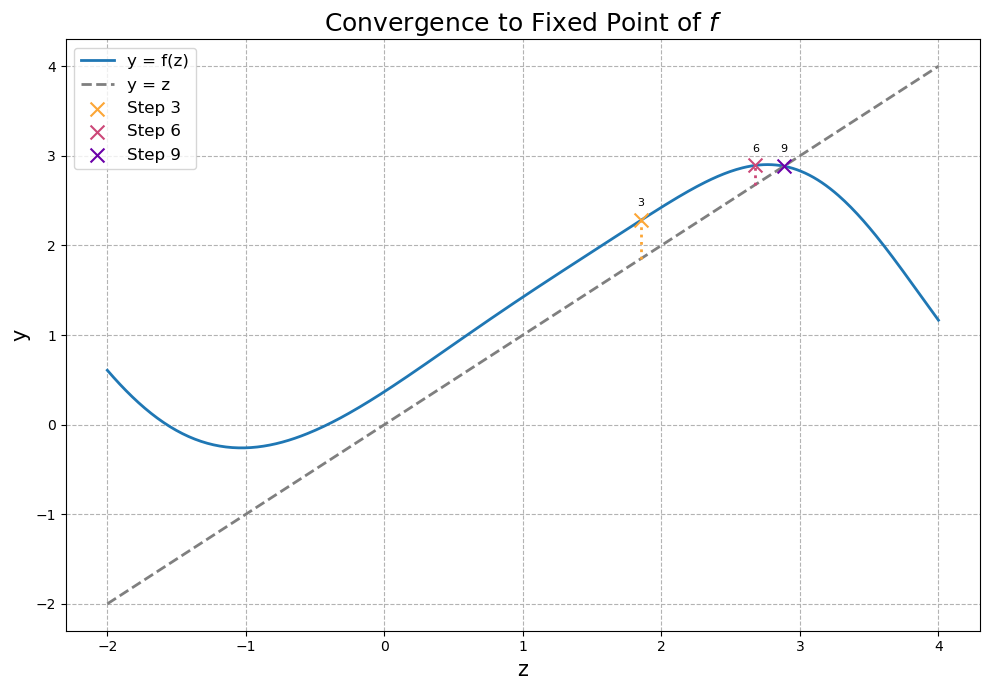

In [6]:
"""
Trajectory Sampling


In some cases, if you want to monitor convergence or apply losses to the trajectory variables, you may need to collect the solver trajectory, 
i.e., solver states at some steps. 
For example, here, we want to visualize the solver states at the 3rd, 6th, and 9th solver steps, respectively. 
You can pass `indexing=[3,6,9]` to `get_deq` to achieve this goal. 
Then, the output `z_out` will include tensors from the 3rd, 6th, and 9th solver steps and the fixed point solution.

In general, you can imagine that this strategy offers **a series that converges to $\mathbf{z}^\star$**. The internal states are tracked gradients automatically as well. We only support phantom gradients on the sampled trajectories as they are coarse fixed point estimations. You can adjust the phantom gradient for each sampled state by setting `grad=[1,2,3]`, for instance.

In this case, we index the solver trajectories and visualize how the numerical solver converges to the fixed point.
"""

# Define a DEQ to sample the solver trajectories
steps = [3, 6, 9]
# core='sliced', indexing
# deq = get_deq(core='indexing', f_solver='broyden', f_max_iter=20, f_tol=1e-6, indexing=steps) # default
# deq = get_deq(core='indexing', f_solver='broyden', f_max_iter=20, f_tol=1e-6, n_states=10)
# deq = get_deq(core='sliced', f_solver='broyden', f_max_iter=20, f_tol=1e-6, indexing=steps)
deq = get_deq(core="sliced", f_solver="broyden", f_max_iter=20, f_tol=1e-6, n_states=10)
# deq = get_deq(core='indexing', f_solver='broyden', f_max_iter=20, f_tol=1e-6)

# Input Injection & The Equilibrium function
x = torch.tensor(1.0)
f = lambda z: x * torch.exp(-torch.cos(z)) + torch.sin(z)

# Solving for the fixed point
z0 = torch.tensor(1.0)
z_out, info = deq(f, z0)

print(f"z_out: {len(z_out)}")

print(f"solver trajectory: {len(z_out)}")
print(f"n_steps: {len(steps)}")

# Obtain solver trajectories
n_steps = len(steps)
convergence_path = z_out[:n_steps]

# Generate data points for the function curve
z_values = torch.linspace(-2, 4, 400)
f_values = f(z_values)

# Plotting and annotating the convergence trajectories
plt.figure(figsize=(10, 7))
plt.plot(z_values, f_values, label="y = f(z)", linewidth=2, color="C0")
plt.plot(z_values, z_values, "--", label="y = z", linewidth=2, color="C7")

colors = plt.cm.plasma(np.linspace(0.8, 0.2, n_steps))

for i, (z, step) in enumerate(zip(convergence_path, steps)):
    f_val = f(z).item()
    plt.scatter(
        z, f_val, color=colors[i], s=100, zorder=5, marker="x", label=f"Step {step}"
    )
    plt.annotate(
        f"{step}",
        (z, f_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8,
    )
    plt.vlines(z, z, f_val, color=colors[i], linestyles="dotted", linewidth=2)

plt.title("Convergence to Fixed Point of $f$", fontsize=18)
plt.xlabel("z", fontsize=15)
plt.ylabel("y", fontsize=15)
plt.grid(True, which="both", ls="--", c="0.7")
plt.legend(loc="best", fontsize=12)
plt.tight_layout()

plt.show()

DEQSliced args: core: sliced
f_max_iter: 20
f_solver: broyden
f_tol: 1.0e-06
 ift: False, hook_ift: False, grad: 1, tau: 1.0, sup_gap: -1, sup_loc: None, n_states: 1, indexing: None
DEQSliced indexing set to: [20]
Sliced indexing set to:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
z_out: 1
solver trajectory: 1
n_steps: 3


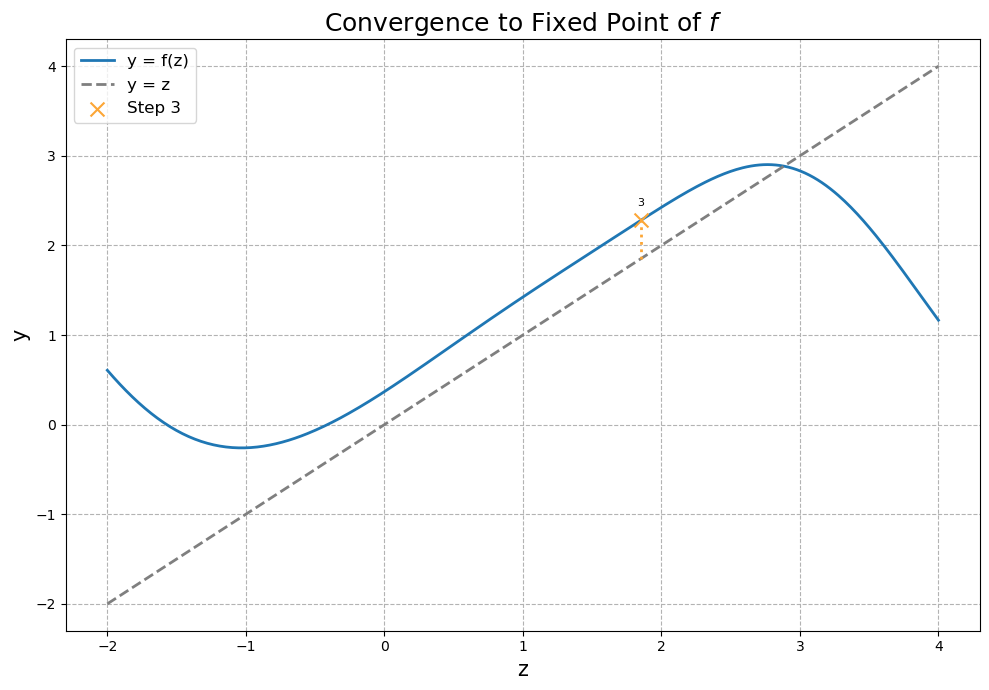

In [7]:
# Same thing again but passing n_states at inference time
"""
Trajectory Sampling


In some cases, if you want to monitor convergence or apply losses to the trajectory variables, you may need to collect the solver trajectory, 
i.e., solver states at some steps. 
For example, here, we want to visualize the solver states at the 3rd, 6th, and 9th solver steps, respectively. 
You can pass `indexing=[3,6,9]` to `get_deq` to achieve this goal. 
Then, the output `z_out` will include tensors from the 3rd, 6th, and 9th solver steps and the fixed point solution.

In general, you can imagine that this strategy offers **a series that converges to $\mathbf{z}^\star$**. The internal states are tracked gradients automatically as well. We only support phantom gradients on the sampled trajectories as they are coarse fixed point estimations. You can adjust the phantom gradient for each sampled state by setting `grad=[1,2,3]`, for instance.

In this case, we index the solver trajectories and visualize how the numerical solver converges to the fixed point.
"""

# Define a DEQ to sample the solver trajectories
steps = [3, 6, 9]
# core='sliced', indexing
# deq = get_deq(core='indexing', f_solver='broyden', f_max_iter=20, f_tol=1e-6, indexing=steps) # default
# deq = get_deq(core='indexing', f_solver='broyden', f_max_iter=20, f_tol=1e-6, n_states=10)
# deq = get_deq(core='sliced', f_solver='broyden', f_max_iter=20, f_tol=1e-6, indexing=steps)
deq = get_deq(core="sliced", f_solver="broyden", f_max_iter=20, f_tol=1e-6)
# deq = get_deq(core='indexing', f_solver='broyden', f_max_iter=20, f_tol=1e-6)

# Input Injection & The Equilibrium function
x = torch.tensor(1.0)
f = lambda z: x * torch.exp(-torch.cos(z)) + torch.sin(z)

# Solving for the fixed point
z0 = torch.tensor(1.0)
z_out, info = deq(f, z0, solver_kwargs={"n_states": 10})

print(f"z_out: {len(z_out)}")

print(f"solver trajectory: {len(z_out)}")
print(f"n_steps: {len(steps)}")

# Obtain solver trajectories
n_steps = len(steps)
convergence_path = z_out[:n_steps]

# Generate data points for the function curve
z_values = torch.linspace(-2, 4, 400)
f_values = f(z_values)

# Plotting and annotating the convergence trajectories
plt.figure(figsize=(10, 7))
plt.plot(z_values, f_values, label="y = f(z)", linewidth=2, color="C0")
plt.plot(z_values, z_values, "--", label="y = z", linewidth=2, color="C7")

colors = plt.cm.plasma(np.linspace(0.8, 0.2, n_steps))

for i, (z, step) in enumerate(zip(convergence_path, steps)):
    f_val = f(z).item()
    plt.scatter(
        z, f_val, color=colors[i], s=100, zorder=5, marker="x", label=f"Step {step}"
    )
    plt.annotate(
        f"{step}",
        (z, f_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8,
    )
    plt.vlines(z, z, f_val, color=colors[i], linestyles="dotted", linewidth=2)

plt.title("Convergence to Fixed Point of $f$", fontsize=18)
plt.xlabel("z", fontsize=15)
plt.ylabel("y", fontsize=15)
plt.grid(True, which="both", ls="--", c="0.7")
plt.legend(loc="best", fontsize=12)
plt.tight_layout()

plt.show()